# Experimental Design
***
## Simulation

Import the necessary packages and code for simulating an experiment.

In [1]:
%matplotlib inline

import numpy as np
import sys
# Add to system path to access simulation code.
sys.path.append('../experimental-design')

from simulate import simulate
from utils import reflectivity

# Reduce size of plots for the notebook.
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (6,4)
plt.rcParams['figure.dpi'] = 100

Next, define the structure that we want to simulate. Here the structure has been defined using [refnx](https://refnx.readthedocs.io/).

In [2]:
from refnx.reflect import SLD

# Defines a structure describing a simple sample.
air = SLD(0, name='Air')
layer1 = SLD(4, name='Layer 1')(thick=100, rough=2)
layer2 = SLD(8, name='Layer 2')(thick=150, rough=2)
substrate = SLD(2.047, name='Substrate')(thick=0, rough=2)

sample_1 = air | layer1 | layer2 | substrate

Here we see what the SLD profile of our simple structure looks like.

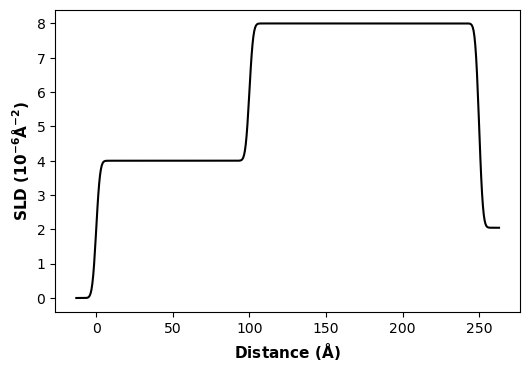

In [3]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(*sample_1.sld_profile(), color='black')
ax.set_xlabel('$\mathregular{Distance\ (\AA)}$', fontsize=11, weight='bold')
ax.set_ylabel('$\mathregular{SLD\ (10^{-6} \AA^{-2})}$', fontsize=11, weight='bold')
plt.show()

To simulate the structure, we need to define the counting times and number of points for each measurement angle. We also specify the experimental scale factor, level of background noise and instrument resolution (in this case a constant 2%).

In [4]:
angle_times = [(0.7, 100, 5), (2.0, 100, 20)] # (Angle, Points, Time)
scale = 1
bkg = 1e-6
dq = 2

# Simulate the experiment.
model_1, data_1 = simulate(sample_1, angle_times, scale, bkg, dq)

We can now plot the simulated data together with the "true" model reflectivity. Note that this data is not stitched; the data from each individual angle has been plotted without any rebinning.

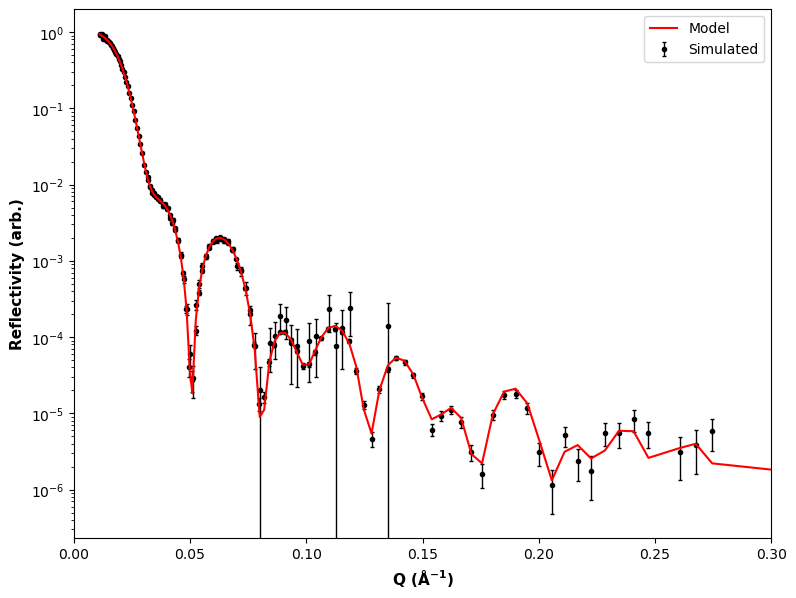

In [5]:
def plot_reflectivity(model, data):
    # Extract each column of the simulated `data`.
    q, r, dr, counts = data[:,0], data[:,1],  data[:,2], data[:,3]

    # Calculate the model reflectivity.
    r_model = reflectivity(q, model)

    # Plot the model and simulated reflectivity against Q.
    fig = plt.figure(figsize=[9,7])
    ax = fig.add_subplot(111)

    # Model reflectivity.
    ax.plot(q, r_model, color='red', zorder=20, label='Model')

    # Simulated reflectivity
    ax.errorbar(q, r, dr, color='black', marker='o', ms=3, lw=0, elinewidth=1, capsize=1.5, label='Simulated')

    ax.set_xlabel('$\mathregular{Q\ (Å^{-1})}$', fontsize=11, weight='bold')
    ax.set_ylabel('Reflectivity (arb.)', fontsize=11, weight='bold')
    ax.set_yscale('log')
    ax.set_xlim(0, 0.3)
    ax.legend()
    plt.show()
    
plot_reflectivity(model_1, data_1)

We can simulate the same structure using [Refl1D](https://refl1d.readthedocs.io/). Note that the way the structure is defined is in the reverse order to refnx (be careful with the direction of interfacial roughnesses if you modify the notebook).

In [6]:
from refl1d.material import SLD

# Defines the same structure as above but using Refl1D
air = SLD(rho=0, name='Air')
layer1 = SLD(rho=4, name='Layer 1')(thickness=100, interface=2)
layer2 = SLD(rho=8, name='Layer 2')(thickness=150, interface=2)
substrate = SLD(rho=2.047, name='Substrate')(thickness=0, interface=2)

sample_2 = substrate | layer2 | layer1 | air

Plot the simulated data like above. As you can see the results are very similar, as is expected.

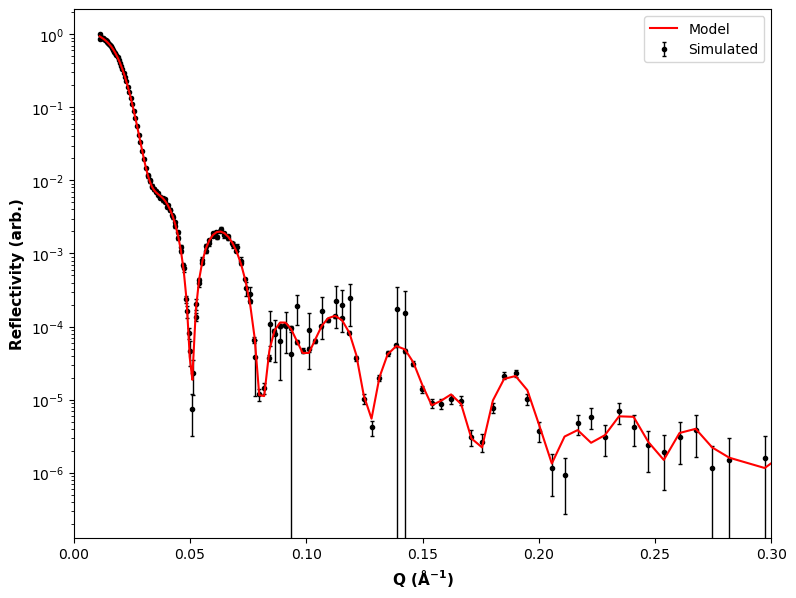

In [7]:
model_2, data_2 = simulate(sample_2, angle_times, scale, bkg, dq)
plot_reflectivity(model_2, data_2)

The following cell demonstrates the equivalence of the RefNX and Refl1D model definitions.

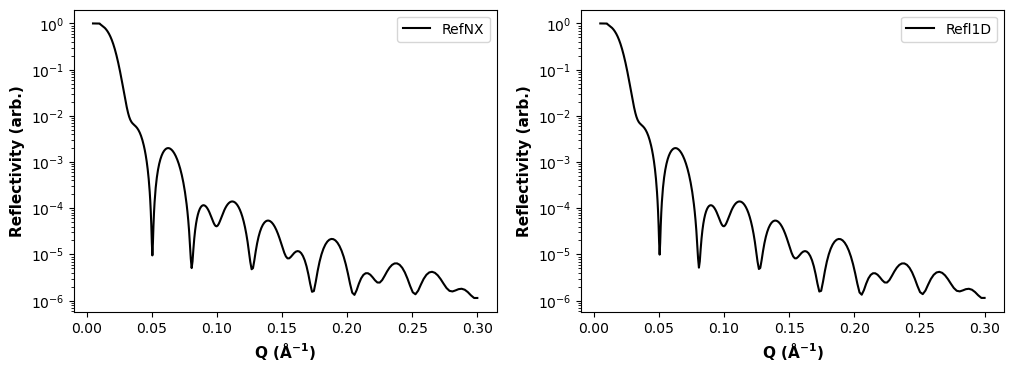

In [8]:
# Define a Q range to consider.
q = np.geomspace(0.005, 0.3, 500)

fig = plt.figure(figsize=[12,4])

# Plot the model reflectivity for the RefNX model.
ax1 = fig.add_subplot(121)
ax1.plot(q, reflectivity(q, model_1), color='black', label='RefNX')
ax1.set_xlabel('$\mathregular{Q\ (Å^{-1})}$', fontsize=11, weight='bold')
ax1.set_ylabel('Reflectivity (arb.)', fontsize=11, weight='bold')
ax1.set_yscale('log')
ax1.legend()

# Plot the model reflectivity for the Refl1D model.
ax2 = fig.add_subplot(122, sharey=ax1)
ax2.plot(q, reflectivity(q, model_2), color='black', label='Refl1D')
ax2.set_xlabel('$\mathregular{Q\ (Å^{-1})}$', fontsize=11, weight='bold')
ax2.set_ylabel('Reflectivity (arb.)', fontsize=11, weight='bold')
ax2.set_yscale('log')
ax2.legend()

plt.show()